# Запуск модели сегментации после обучения в GPU

In [1]:
import albumentations as albu
import torch
import segmentation_models_pytorch as smp
import numpy as np

In [7]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['walrus']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth" to /Users/michil/.cache/torch/hub/checkpoints/se_resnext50_32x4d-a260b3a4.pth


  0%|          | 0.00/105M [00:00<?, ?B/s]

In [19]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [24]:
model = torch.load('models/best_model.pth', map_location=torch.device('cpu'))

In [25]:
preprocessing = get_preprocessing(preprocessing_fn)

In [47]:
image_vis = cv2.imread('data/min_of_nature/images/DJI_0001 (2).JPG')
image = preprocessing(image=image_vis)['image']

In [50]:
%%time

output_mask = np.zeros(image.shape[1:])


for x_end in range(480, image_vis.shape[1] + 480, 480):
    for y_end in range(384, image_vis.shape[0] + 384, 384):
        y_end = min(y_end, image_vis.shape[0])
        x_end = min(x_end, image_vis.shape[1])
        
        image_part = image[:, y_end-384:y_end, x_end-480:x_end]
        image_vis_part = image_vis[y_end-384:y_end, x_end-480:x_end, :]
        
        x_tensor = torch.from_numpy(image_part).type(torch.FloatTensor).to(DEVICE).unsqueeze(0)
        pr_mask = model.predict(x_tensor)
        pr_mask = pr_mask.squeeze().round().detach().cpu().numpy()
    
        output_mask[y_end-384:y_end, x_end-480:x_end] = pr_mask

CPU times: user 1min 26s, sys: 9.73 s, total: 1min 36s
Wall time: 1min 24s


In [51]:
import matplotlib.pyplot as plt

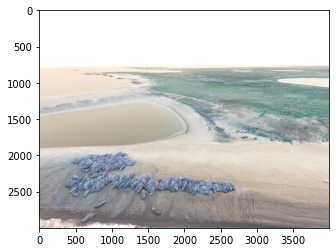

In [52]:
plt.imshow(image_vis)

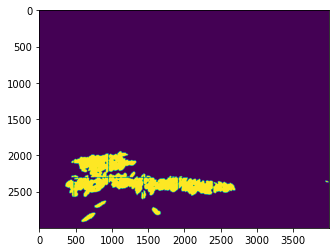

In [53]:
plt.imshow(output_mask)